In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [22]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation_cleaned.csv")

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="real_estate_valuation_cleaned", explorative=True)

# Get the description object
desc_full = profile_full.get_description()

# Access the correlation matrix
correlation_matrix = desc_full.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
categorical_cols = get_categorical_columns(data)
distributions = fit_distributions(data)
marginals = convert_distfit_to_marginals(distributions, data)

In [5]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=500, correlation_threshold=0.1, edge_strategy="random", sampling_strategy="local-chunks")

In [6]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="real_estate_valuation_cleaned SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [8]:
from sdmetrics.reports.single_table import QualityReport

data_syn = data_syn[data.columns.to_list()]

metadata = {
    "columns": {
        "X1 house age": {"sdtype": "numerical"},
        "X2 distance MRT station": {"sdtype": "numerical"},
        "X3 number convenience stores": {"sdtype": "numerical"},
        "X4 lat": {"sdtype": "numerical"},
        "X5 long": {"sdtype": "numerical"},
        "X6 price": {"sdtype": "numerical"}
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 924.60it/s]|
Column Shapes Score: 87.98%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 152.97it/s]|
Column Pair Trends Score: 92.41%

Overall Score (Average): 90.19%



In [9]:
# variable assignment according to correlation structure
independents_lst = ['X2 distance MRT station', 'X3 number convenience stores', 'X4 lat']
dependent_var = 'X6 price'
X = data_syn[independents_lst].to_numpy()
y = data_syn[dependent_var].to_numpy()

27.4**2 * RBF(length_scale=30) + WhiteKernel(noise_level=40)


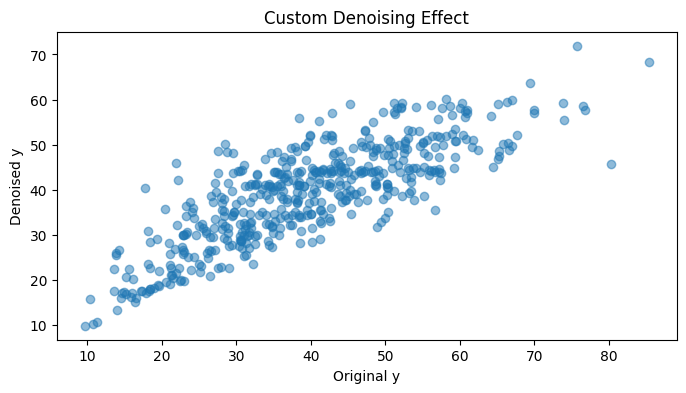

In [10]:
%matplotlib inline
y_denoised = bound_denoise(X, y, length_scale_bounds=(1e-3, 30), noise_level_bounds=(1e-5, 40), show_denoising_effect=True)

In [11]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log", "abs", "sqrt"],
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y_denoised)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          39.349125   
	1         0.088585                                     x1 + 34.845894   
	2         0.848766                                244.48051 / log(x0)   
	3         0.119748                        96543.77 / (x0 + 1766.0225)   
	4         0.171585                        1924.5802 / (x2 + sqrt(x0))   
	5         0.054240         (23193.719 / (x0 + 536.6815)) - -18.351387   
	6         0.001153  (23193.56 / ((x0 - x1) + 543.29034)) - -18.376554   
	7         0.004926  x2 + abs(7.8791614 - (25571.531 / (x0 + 579.08...   
	8         0.023741  (23192.344 / (x0 + 558.1173)) - ((x2 * -80.218...   
	9         0.000002  abs((x2 * -80.23929) + (1984.6719 - (23192.344...   
	10        0.002199  (23192.168 / (x0 + (564.8633 - x1))) - ((x2 * ...   
	11        0.013827  ((x2 - cos(x0 / 25.372671)) + (22771.092 / (x0...   
	12        0.005836  (x2 - cos(x0 / 25.373589)) + abs((22771.375 / ...   
	13        0.018829  ((x2 * x2) - cos(x0 / 25.374039)) + ((22770.54...   
	14        0.017343  (22768.754 / (x0 + 542.1646)) + ((x2 * x2) - (...   
	15        0.012557  ((22768.89 / (x0 + 532.38184)) + 18.683464) - ...   
	16        0.025534  ((22768.893 / (x0 + 532.6685)) + 18.764418) - ...   
	17        0.000581  (18.765015 - ((((x0 / 13.897569) / (x2 + sin(x...   
	18        0.005035  (18.781195 - (((((x0 / 13.609729) / x2) - sin(...   
	19        0.054575  (x2 * x2) + (((22768.754 / (x0 + 543.8294)) - ...   
	20        0.001246  (x2 * x2) + (((22768.754 / (x0 + 543.8294)) - ...   
	21        0.059828  (((22768.79 / (x0 + 541.9767)) + (x2 * x2)) - ...   
	22        0.023686  abs(((x2 * x2) - 604.69055) - ((((cos(x0 / (x2...   
	23        0.011997  abs((cos(x0 / (x2 + 0.40057173)) * (((x0 / sqr...   
	24        0.007012  abs(((x2 * x2) - 604.60803) - ((x0 / (sqrt(sqr...   
	25        0.003912  abs((cos(x0 / (x2 + 0.4014634)) * (((x0 / (sin...   
	26        0.012519  abs(((x2 * x2) - 604.6401) - ((((x1 * x1) + ((...   
	27        0.045524  ((x2 * x2) + ((22769.266 / (x0 + 542.84357)) -...   
	28  >>>>  0.088734  (((x2 * x2) + (22769.266 / (x0 + 542.87085))) ...   
	29        0.033104  (22769.266 / (x0 + 539.13696)) + abs(((((x0 / ...   
	30        0.006075  (22769.266 / (x0 + 540.64435)) + abs((((x1 + (...   
	31        0.002319  (22768.754 / (x0 + 543.8294)) + abs(((cos(x0 /...   
	32        0.002208  abs(((x2 * x2) - 604.58484) - (cos(x0 / (x2 + ...   
	33        0.001565  (22768.754 / (x0 + 543.8294)) + abs(((((x0 * c...   
	34        0.000796  (22768.754 / (x0 + 545.6171)) + abs(((x0 * ((c...   
	35        0.018682  abs(((cos(x0 / (x2 + 0.3938882)) * ((x1 * x1) ...   
	36        0.003184  abs(((x2 * x2) - 604.58484) - (((x1 * x1) + ((...   
	37        0.022662  (22769.266 / (x0 + 545.51263)) + abs(((x2 * x2...   
	38        0.002434  abs(((x2 * x2) - 604.58484) - ((((x1 * x1) + (...   
	39        0.009486  (22769.266 / (x0 + 545.51263)) + abs(((x2 * x2...   
	40        0.000067  (22768.754 / (x0 + 542.1646)) + abs(((((x0 / (...   
	41        0.010979  (22768.754 / (542.1646 + x0)) + abs(((((x0 / (...   
	
	          loss  complexity  
	0   117.525330           1  
	1    98.443630           3  
	2    42.128230           4  
	3    37.373806           5  
	4    31.481035           6  
	5    29.818990           7  
	6    29.750286           9  
	7    29.604094          10  
	8    28.909554          11  
	9    28.909485          12  
	10   28.845990          13  
	11   28.449879          14  
	12   28.284342          15  
	13   27.756748          16  
	14   27.279516          17  
	15   26.939098          18  
	16   25.597898          20  
	17   25.553339          23  
	18   25.297321          25  
	19   23.953709          26  
	20   23.923887          27  
	21   22.534536          28  
	22   22.007050          29  
	23   21.744612          30  
	24   21.592663          31  
	25   2

In [22]:
# 20250423_220042_fVG3Ec
# Complexity 13
candidate_function = generate_candidate_function("(23192.168 / (x0 + (564.8633 - x1))) - ((x2 * -80.24144) + 1984.6936)")

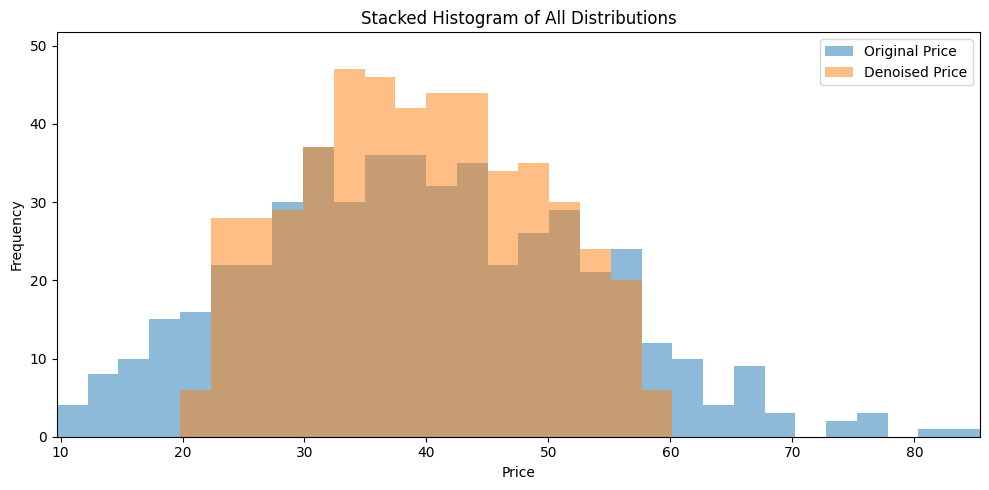

In [23]:
%matplotlib inline
y_denoised = candidate_function(X)
plot_histograms([(y, 'Original Price', None), (y_denoised, 'Denoised Price', None)], 'Price', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

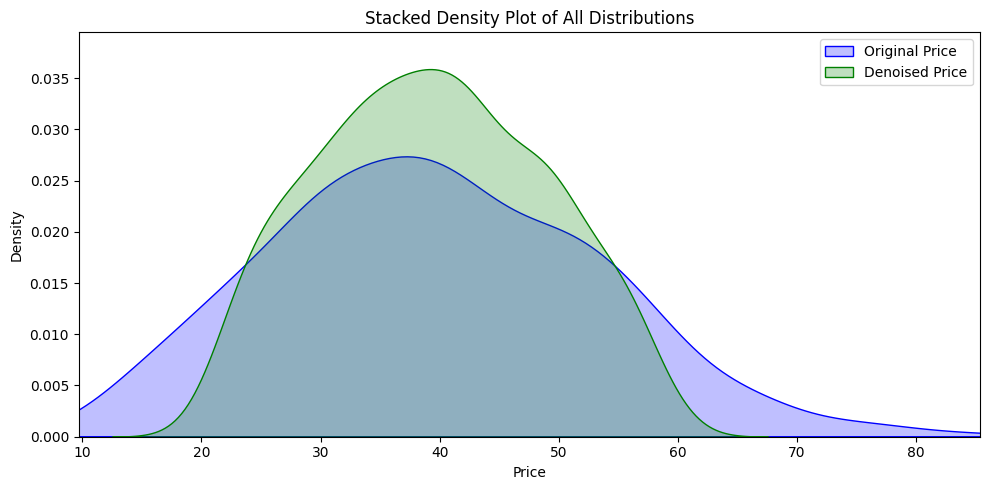

In [24]:
plot_densities([(y, 'Original Price', 'blue'), (y_denoised, 'Denoised Price', 'green')], 'Price', stack=True, figsize_per_plot=(10, 5))

In [25]:
orig_residuals = y - y_denoised

In [26]:
y_renoised, best_amp, errors, _ = renoise_predictions(y, y_denoised, method='stratified', seed=42, clip_lower=0, clip_upper=None, original_residuals=None, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run

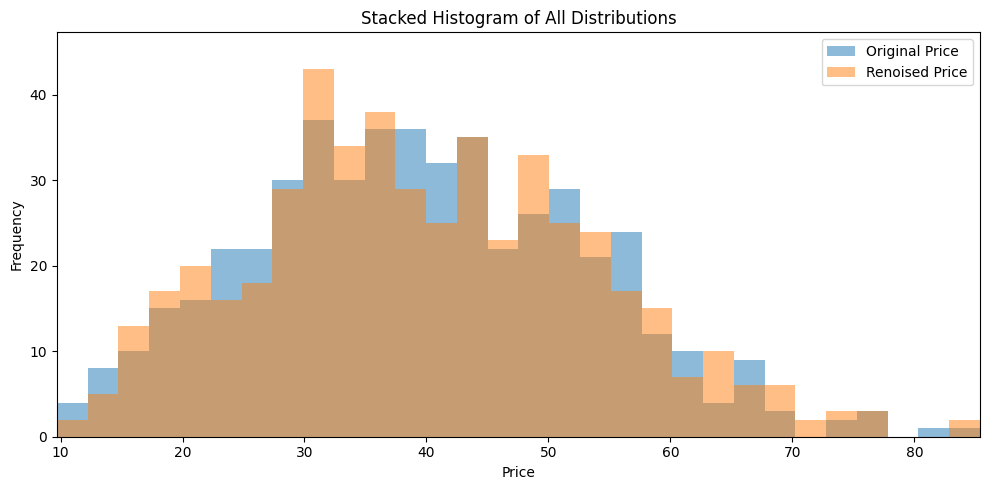

In [27]:
plot_histograms([(y, 'Original Price', None), (y_renoised, 'Renoised Price', None)], 'Price', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

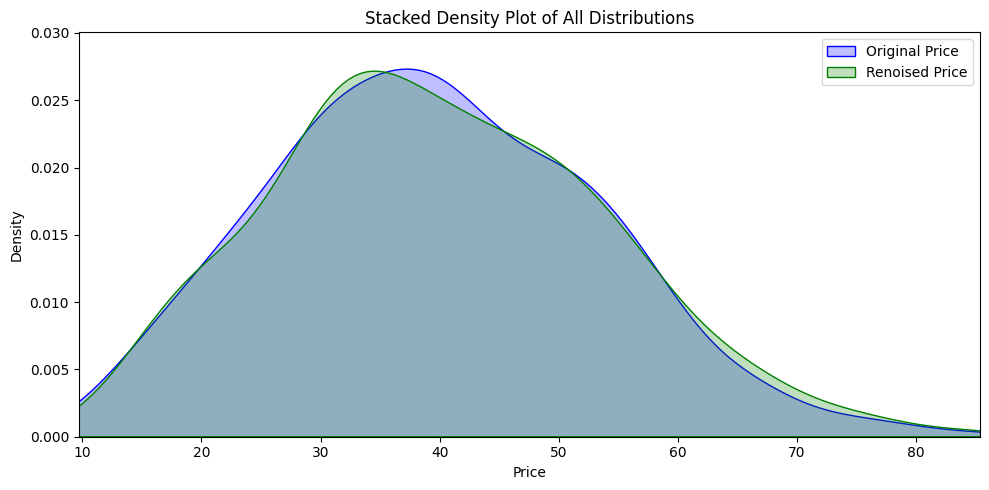

In [28]:
plot_densities([(y, 'Original Price', 'blue'), (y_renoised, 'Renoised Price', 'green')], 'Price', stack=True, figsize_per_plot=(10, 5))

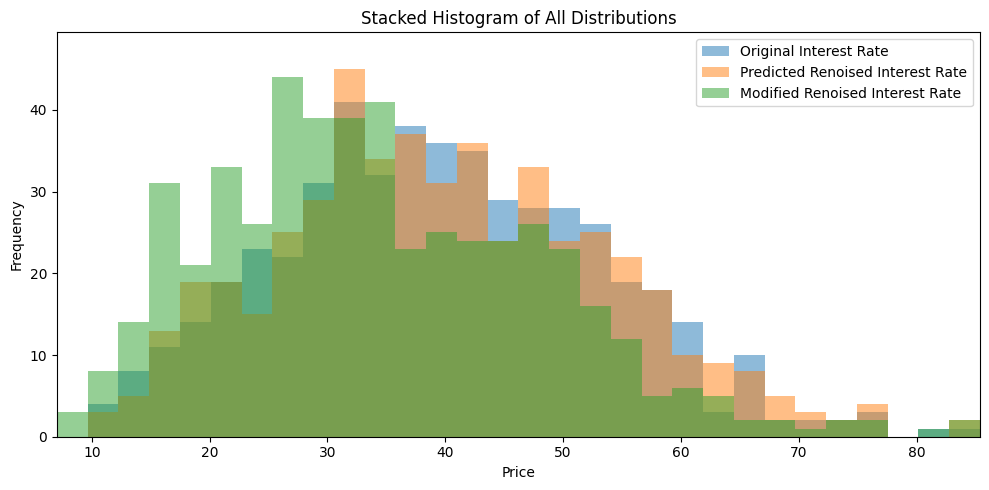

In [30]:
mod_candidate_function = generate_candidate_function("(23192.168 / (2*x0 + (564.8633 - x1))) - ((x2 * -80.24144) + 1984.6936)")
mod_y_pred = mod_candidate_function(X)
mod_y_pred_corrected, best_amp, errors, _ = renoise_predictions(y, mod_y_pred, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y, 'Original Interest Rate', None), (y_renoised, 'Predicted Renoised Interest Rate', None), (mod_y_pred_corrected, 'Modified Renoised Interest Rate', None)], 'Price', stack=True, figsize_per_plot=(10, 5))